In [3]:
from pathlib import Path
from dotenv import load_dotenv
import os

load_dotenv()
dataset_location = Path(os.environ.get('DATA', None))

dataset_location.exists()

True

In [4]:
import pandas as pd

In [5]:
metadata = pd.read_csv(dataset_location / 'RST_3000.csv')
metadata.pop('GlobalSeed')
metadata.pop('CaseSeed')

0       219690
1       253164
2       750130
3       115753
4         4910
         ...  
2995    238912
2996    799368
2997    999668
2998     96048
2999    533641
Name: CaseSeed, Length: 3000, dtype: int64

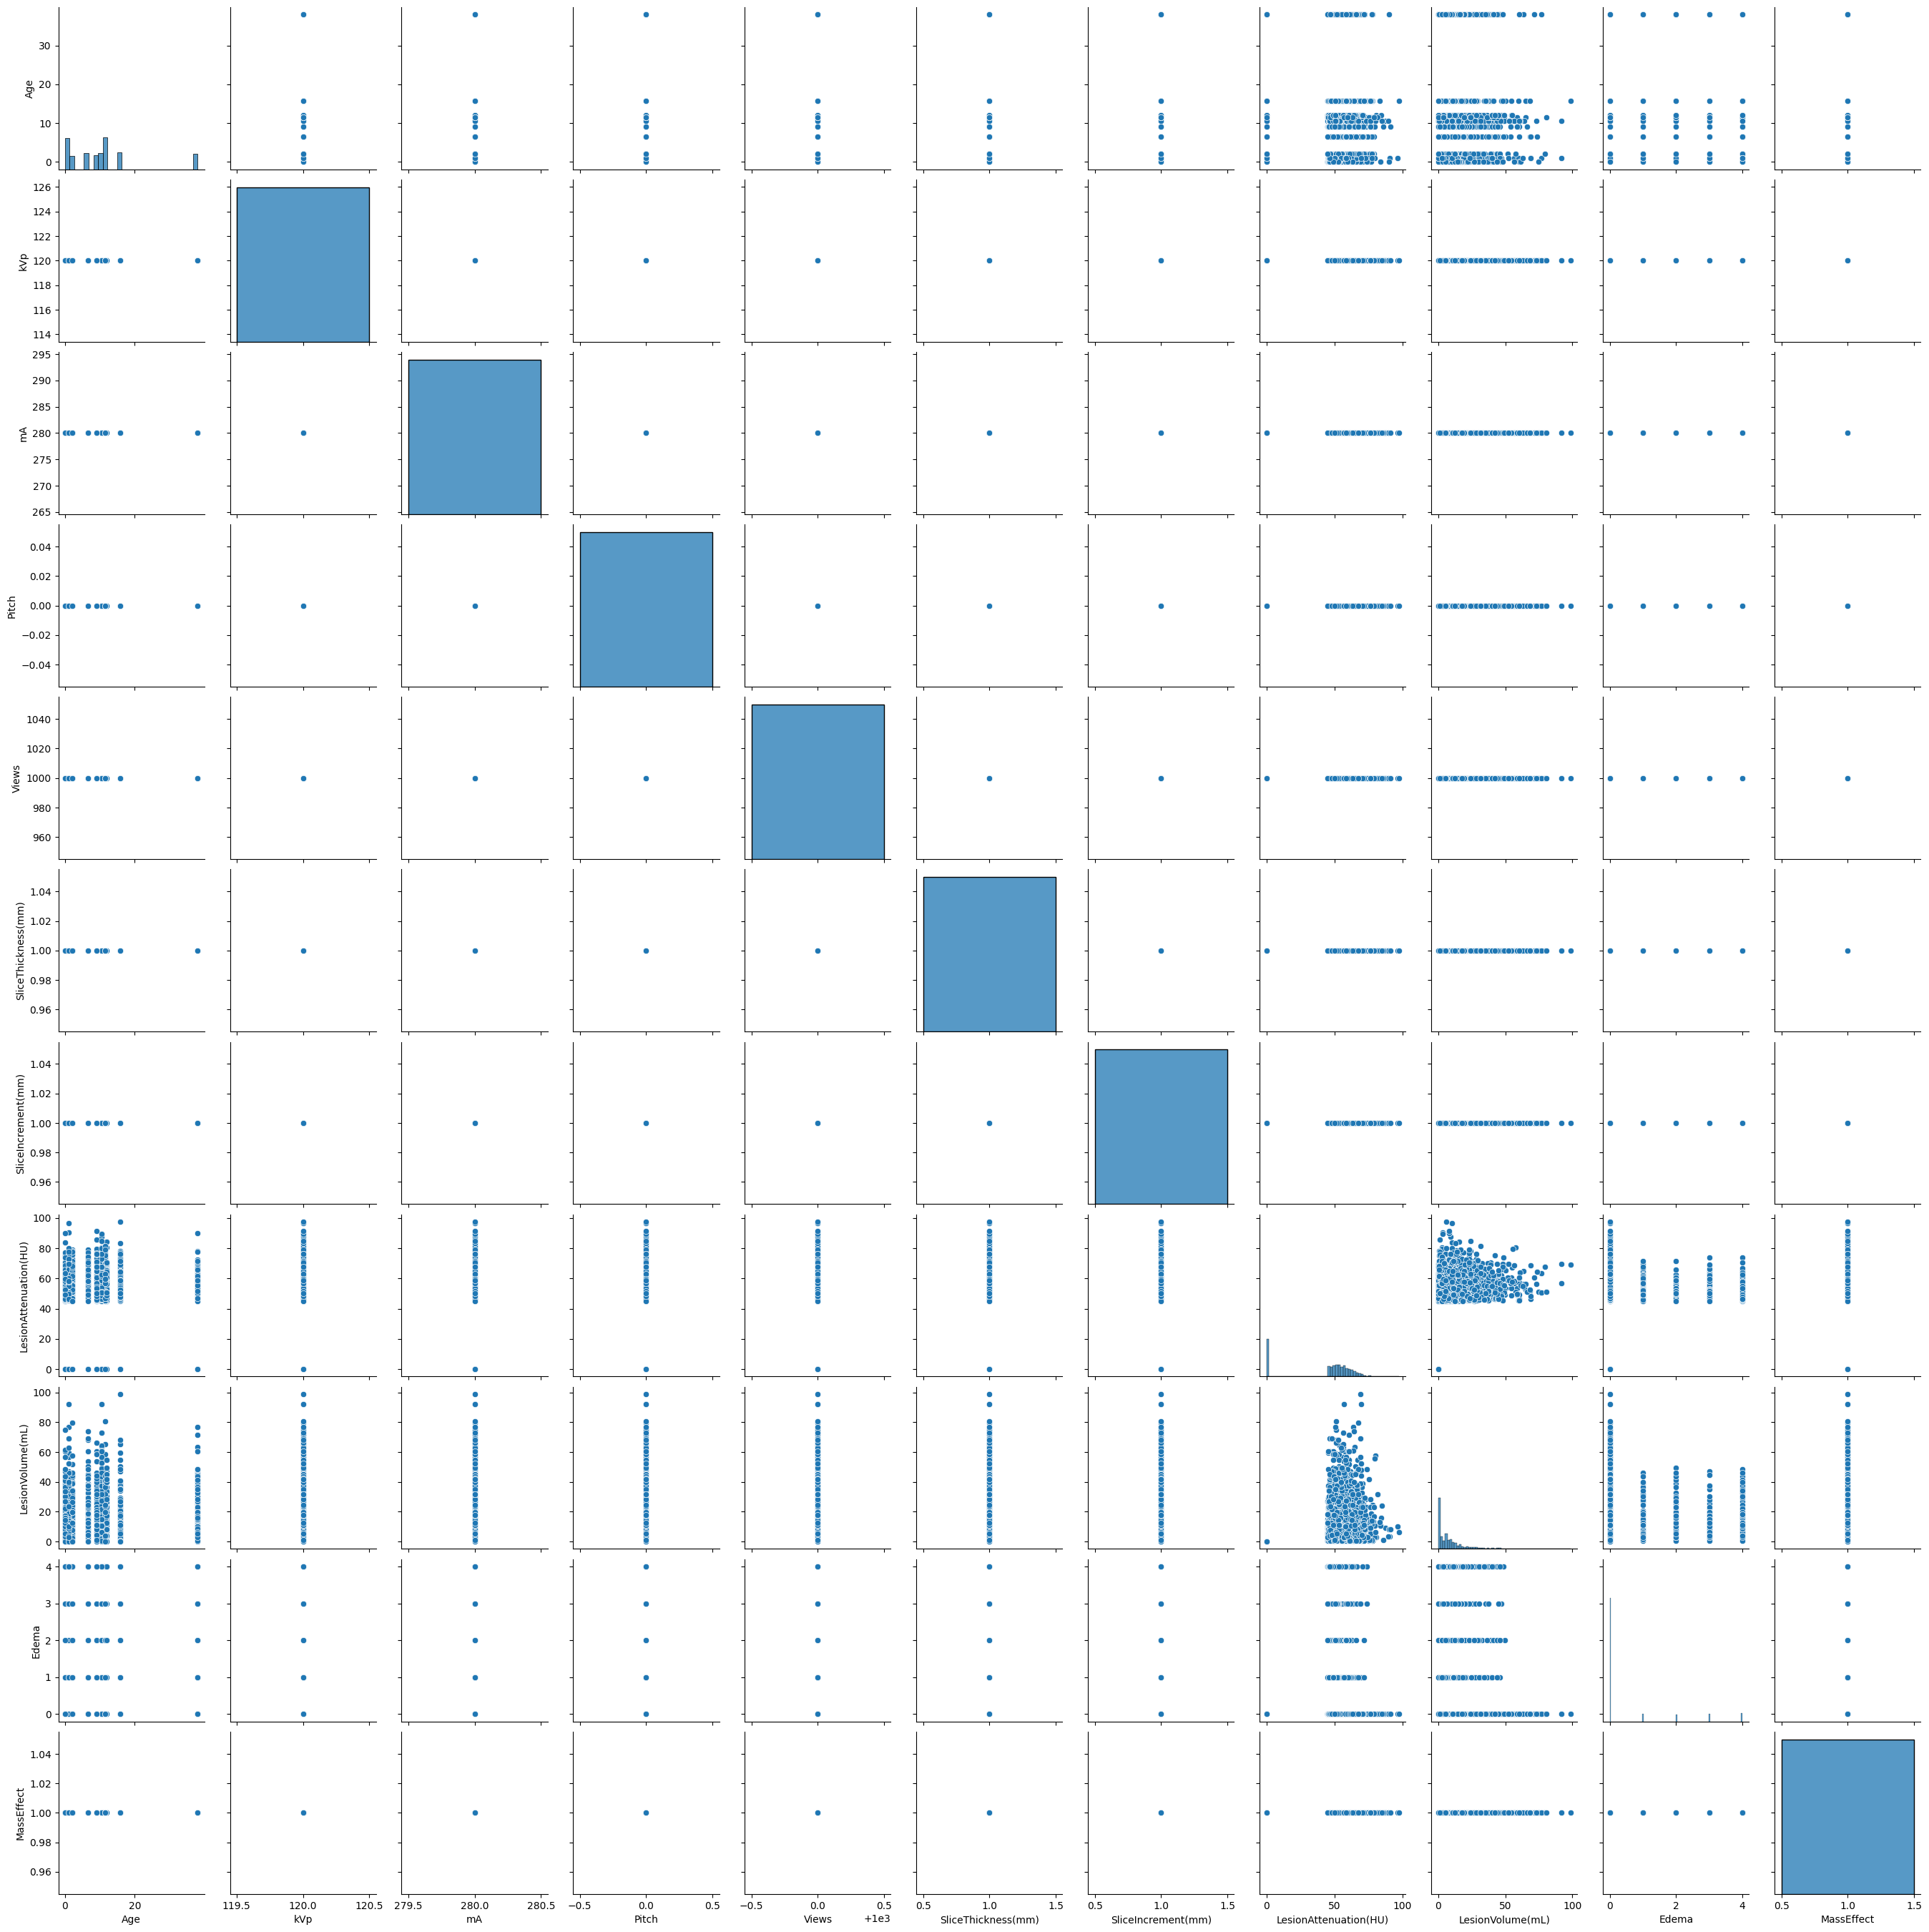

In [6]:
import seaborn as sns
sns.pairplot(metadata)

In [7]:
import SimpleITK as sitk

In [9]:
case_ids = metadata.CaseID.unique()
case_ids

array(['case_000', 'case_001', 'case_002', ..., 'case_2997', 'case_2998',
       'case_2999'], shape=(3000,), dtype=object)

In [77]:
metadata

,CaseID,Age,Scanner,kVp,mA,Pitch,Views,ScanCoverage,ReconKernel,SliceThickness(mm),SliceIncrement(mm),LesionAttenuation(HU),Subtype,LesionVolume(mL),Edema,MassEffect,OutputDirectory
0,case_000,2.00,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,45.993079,IPH,7.651164,0,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
1,case_001,9.00,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,53.011883,IPH,8.851580,3,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
2,case_002,6.50,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,59.153337,IPH,8.851580,1,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
3,case_003,1.00,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,0.000000,NaN,0.000000,0,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
4,case_004,9.00,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,57.894345,SDH,4.403668,0,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,case_2995,38.00,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,51.580296,SDH,5.354621,0,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
2996,case_2996,9.00,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,67.690894,EDH,31.486601,0,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
2997,case_2997,15.75,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,0.000000,NaN,0.000000,0,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...
2998,case_2998,15.75,GE_Lightspeed16,120.0,280.0,0.0,1000.0,dynamic,standard,1,1,58.714661,IPH,5.250334,2,True,/projects01/didsr-aiml/jayse.weaver/insilicoic...


In [16]:
case_id = case_ids[0]
image_path = dataset_location / case_id / 'dicoms'
mask_path = dataset_location / case_id / 'lesion_masks'
image_files = sorted(list(image_path.rglob('*.dcm')))
mask_files = sorted(list(mask_path.rglob('*.dcm')))
vol = sitk.GetArrayFromImage(sitk.ReadImage(image_files))
mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_files)) if mask_files else None
vol.shape, mask.shape

((105, 512, 512), (105, 512, 512))

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

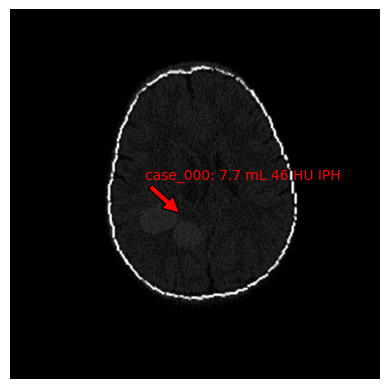

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import center_of_mass

coords = center_of_mass(mask.mean(axis=0))
coords = np.array(coords)[::-1]
row = metadata[metadata.CaseID == case_id]
midslice = mask.sum(axis=(1,2)).argmax() if mask_files else vol.shape[0] // 2
window, level = 300, 150
vmin = level - window//2
vmax = level + window//2
plt.imshow(vol[midslice], cmap='gray', vmin=vmin, vmax=vmax)
ann_str = f"{row['CaseID'].item()}: {row['LesionVolume(mL)'].item():2.1f} mL {row['LesionAttenuation(HU)'].item():2.0f} HU {row['Subtype'].item()}" if mask_files else ''
if ann_str:
    plt.annotate(ann_str, coords, arrowprops=dict(facecolor='red', shrink=0.05), xytext = coords - np.array(50), color='red')
plt.axis('off')
# if mask_files:
#     plt.imshow(mask[midslice], cmap = 'Reds', alpha=0.2)